Door Dennis Besselsen, Levi Verhoef, Emiel Verhoef (geen familie!)
V2A, 2021 

We beginnen met het importeren van een aantal libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import pearsonr
from scipy.stats import stats
from sklearn.cluster import KMeans
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import svm
from math import sqrt

Hier lezen we onze beide databases alvast in:

In [2]:
#the film database from the assignment
table = pd.read_csv("movie.csv")

#film database we found online(https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset)
table2 =  pd.read_csv("IMDB_movies.csv", low_memory = False)

# show big float values as actual number - not scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x) 


<h2>Onderzoeksvragen:</h2>

1. In hoeverre is de omzet van een film te voorspellen op basis van de populariteit op Facebook en IMDB?
2. Kun je voorspellen of een film winst of verlies heeft gemaakt, of gaat maken, op basis van variabelen in de database?
3. Kunnen we logische klusters vinden van regisseurs die winstgevende films maken of regisseurs die vaak verliesgevende films maken?

<h1> Featurevariabelen: </h1>
We hebben een aantal featurevariabelen gekozen die passen bij onze onderzoeksvragen. 

**director_name**: een **nominale meetwaarde** waarin de naam van de regisseur staat.
Director name heeft af en toe geen ingevulde waarde. Dat maakt voor onze onderzoeksvragen niet veel uit.

**num_voted_users**: een **discrete meetwaarde** die ons laat zien hoeveel mensen op een film hebben gestemd op IMDb.
Deze featurevariabele gebruiken we als één van onze maatstaven voor IMDb populariteit. Hoe meer mensen stemmen op een film, hoe hoger de populariteit. 
Dit is direct een handige variabele voor onze eerste onderzoeksvraag. 

**num_critic_for_reviews**: een **discrete meetwaarde** die ons laat zien hoeveel critici een film hebben gerecenseerd.
Deze featurevariabele is een andere maatstaf voor populariteit van een film op IMDb. Ook deze variabele lijkt op eerste oogopslag erg interessant voor onderzoeksvraag 1.

**num_user_for_reviews**: een **discrete meetwaarde** die ons laat zien hoeveel IMDb gebruikers een film hebben gerecenseerd.
Dit is de derde meetwaarde die IMDb populariteit aangeeft. Een review achterlaten is meer moeite dan simpelweg stemmen, 
dus wellicht dat de waardes voor deze featurevariabele zwaarder wegen of een sterkere correlatie aangeven dan de voorgaande variabelen die te maken hadden met IMDb populariteit.

**imdb_score**: een **discrete meetwaarde** die de score van een film weergeeft.
IMDB score is één van onze targetvariabelen en zodoende nemen we deze sowieso mee in onze dataset.

**movie_facebook_likes**: een **discrete meetwaarde** die de hoeveelheid likes die een film op facebook heeft weergeeft.
Movie_facebook_likes is de meetwaarde die we gebruiken om te bepalen hoe populair een film op facebook is, wat één van onze directe featurevariabelen is voor onderzoeksvraag 1.

**budget**: een **continue meetwaarde** die aangeeft hoeveel geld er is besteed aan het produceren van een film.
Budget is een meetwaarde die we sowieso interessant vonden om mee te nemen, eventueel voor onderzoeksvraag 2. 
We kwamen er al snel achter dat er een paar vreemde uitschieteres zijn, maar die zijn vrij simpel te verhelpen. Verder zullen we hier ook nog de waardes moeten normaliseren, gezien er af en toe waardes tussen zitten die in een andere munteenheid
Er zijn best veel entries in onze dataframe met null-waardes op "budget", dus we kiezen ervoor om die te droppen, gezien we deze featurevariabele centraal stellen in onze onderzoeksvraag.

**gross**: een **continue meetwaarde** die aangeeft hoeveel omzet een film heeft gedraaid.
Gross is een meetwaarde die in meerdere van onze onderzoeksvragen een vrij prominente rol speelt. 

<h2> Eerste kijk in de database met gekozen feature variabelen</h2>

We gebruiken hier describe() om inzicht te krijgen in de centrum- en spreidingsmaten van onze gekozen variabelen.

In [3]:
#trim tables so we only have feature variables
feature_table = table[['movie_title','duration', 'movie_imdb_link', 'num_voted_users', 'num_critic_for_reviews', 'num_user_for_reviews','imdb_score', 'movie_facebook_likes','budget', 'gross', 'director_name']]

# change the movie_imdb_link to a imdb_title_id
feature_table["movie_imdb_link"]= feature_table["movie_imdb_link"].str.split("/", n = 5, expand = True)[4]
feature_table = feature_table.rename(columns={"movie_imdb_link": "imdb_title_id"})

# Use describe function to show the central tendency and dispersion values, of only the feature variables
feature_table.describe()


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,duration,num_voted_users,num_critic_for_reviews,num_user_for_reviews,imdb_score,movie_facebook_likes,budget,gross
count,5028.000,5043.000,4993.000,5022.000,5043.000,5043.000,4551.000,4159.000
mean,107.201,83668.161,140.194,272.771,6.442,7525.965,39752620.436,48468407.527
std,25.197,138485.257,121.602,377.983,1.125,19320.445,206114898.449,68452990.439
min,7.000,5.000,1.000,1.000,1.600,0.000,218.000,162.000
25%,93.000,8593.500,50.000,65.000,5.800,0.000,6000000.000,5340987.500
50%,103.000,34359.000,110.000,156.000,6.600,166.000,20000000.000,25517500.000
75%,118.000,96309.000,195.000,326.000,7.200,3000.000,45000000.000,62309437.500
max,511.000,1689764.000,813.000,5060.000,9.500,349000.000,12215500000.000,760505847.000


Een aantal observaties:
    
We hebben ~5000 films in onze eerste database. 

De budget feature mist ~10% van zijn waardes, de gross feature bijna 20%.

Alle andere features missen maar een heel klein deel van hun waardes.

In [4]:
feature_table.dtypes

movie_title                object
duration                  float64
imdb_title_id              object
num_voted_users             int64
num_critic_for_reviews    float64
num_user_for_reviews      float64
imdb_score                float64
movie_facebook_likes        int64
budget                    float64
gross                     float64
director_name              object
dtype: object

Zoals we in dit korte overzicht kunnen zien zijn veruit de meeste featurevariabelen die we hebben gekozen numeriek. We hebben een aantal nominale, namelijk director_name, movie_title en imdb_title_id.

Imdb_title_id gebruiken we eigenlijk vooral als primary key, om later onze tweede dataset op te joinen.

<h2>Business understanding van de data </h2>

We kunnen handmatig alvast een paar van onze variabelen checken doormiddel van business understanding.

We beginnen hier met budget. Een simpele google zoekopdracht verteld ons dat Avengers: Endgame de hoogstgebudgeteerde film ooit is met een budget van $400m usd. Alle waardes die daar boven uitkomen, zijn dus sowieso incorrect.

Als we in de database kijken kunnen we zien dat onze database nog van voor die tijd is, en de hoogstgebudgeteerde film in onze database is Pirates of the Caribbean: At World's End, met 300m USD. Er zijn 13 films met een waarde daarboven, dus daar is duidelijk of de verkeerde munteenheid gebruikt, of iets niet goed gegaan met de conversie. 

We kijken hier naar de top 30 films gesorteerd op budget:

In [5]:

feature_table.nlargest(30, 'budget')

,movie_title,duration,imdb_title_id,num_voted_users,num_critic_for_reviews,num_user_for_reviews,imdb_score,movie_facebook_likes,budget,gross,director_name
2988,The Host,110.000,tt0468492,68883,363.000,279.000,7.000,7000,12215500000.000,2201412.000,Joon-ho Bong
3859,Lady Vengeance,112.000,tt0451094,53508,202.000,131.000,7.700,4000,4200000000.000,211667.000,Chan-wook Park
3005,Fateless,134.000,tt0367082,5603,73.000,45.000,7.100,607,2500000000.000,195888.000,Lajos Koltai
2323,Princess Mononoke,134.000,tt0119698,221552,174.000,570.000,8.400,11000,2400000000.000,2298191.000,Hayao Miyazaki
2334,Steamboy,103.000,tt0348121,13727,105.000,79.000,6.900,973,2127519898.000,410388.000,Katsuhiro Ôtomo
3423,Akira,124.000,tt0094625,106160,150.000,430.000,8.100,0,1100000000.000,439162.000,Katsuhiro Ôtomo
4542,Godzilla 2000,99.000,tt0188640,5442,107.000,140.000,6.000,339,1000000000.000,10037390.000,Takao Okawara
3075,Kabhi Alvida Naa Kehna,193.000,tt0449999,13998,20.000,264.000,6.000,659,700000000.000,3275443.000,Karan Johar
3851,Tango,115.000,tt0120274,2412,35.000,40.000,7.200,539,700000000.000,1687311.000,Carlos Saura
3273,Kites,90.000,tt1198101,9673,41.000,106.000,6.000,0,600000000.000,1602466.000,Anurag Basu


Hieronder verwijderen we alle rows met een budgetwaarde boven de 300m USD

In [6]:
feature_table = feature_table[feature_table['budget'] < 300000000]
feature_table.nlargest(30, 'budget')

,movie_title,duration,imdb_title_id,num_voted_users,num_critic_for_reviews,num_user_for_reviews,imdb_score,movie_facebook_likes,budget,gross,director_name
5,John Carter,132.000,tt0401729,212204,462.000,738.000,6.600,24000,263700000.000,73058679.000,Andrew Stanton
7,Tangled,100.000,tt0398286,294810,324.000,387.000,7.800,29000,260000000.000,200807262.000,Nathan Greno
6,Spider-Man 3,156.000,tt0413300,383056,392.000,1902.000,6.200,0,258000000.000,336530303.000,Sam Raimi
3461,Spider-Man 3,156.000,tt0413300,383071,392.000,1902.000,6.200,0,258000000.000,336530303.000,Sam Raimi
3,The Dark Knight Rises,164.000,tt1345836,1144337,813.000,2701.000,8.500,164000,250000000.000,448130642.000,Christopher Nolan
8,Avengers: Age of Ultron,141.000,tt2395427,462669,635.000,1117.000,7.500,118000,250000000.000,458991599.000,Joss Whedon
9,Harry Potter and the Half-Blood Prince,153.000,tt0417741,321795,375.000,973.000,7.500,10000,250000000.000,301956980.000,David Yates
10,Batman v Superman: Dawn of Justice,183.000,tt2975590,371639,673.000,3018.000,6.900,197000,250000000.000,330249062.000,Zack Snyder
18,Pirates of the Caribbean: On Stranger Tides,136.000,tt1298650,370704,448.000,484.000,6.700,58000,250000000.000,241063875.000,Rob Marshall
20,The Hobbit: The Battle of the Five Armies,164.000,tt2310332,354228,422.000,802.000,7.500,65000,250000000.000,255108370.000,Peter Jackson


Hier kijken we naar de top 30 US_gross, dit ziet er goed uit. Geen onverwachte filmtitels.

In [7]:
feature_table.nlargest(30, 'gross')

,movie_title,duration,imdb_title_id,num_voted_users,num_critic_for_reviews,num_user_for_reviews,imdb_score,movie_facebook_likes,budget,gross,director_name
0,Avatar,178.000,tt0499549,886204,723.000,3054.000,7.900,33000,237000000.000,760505847.000,James Cameron
26,Titanic,194.000,tt0120338,793059,315.000,2528.000,7.700,26000,200000000.000,658672302.000,James Cameron
29,Jurassic World,124.000,tt0369610,418214,644.000,1290.000,7.000,150000,150000000.000,652177271.000,Colin Trevorrow
17,The Avengers,173.000,tt0848228,995415,703.000,1722.000,8.100,123000,220000000.000,623279547.000,Joss Whedon
794,The Avengers,173.000,tt0848228,995415,703.000,1722.000,8.100,123000,220000000.000,623279547.000,Joss Whedon
66,The Dark Knight,152.000,tt0468569,1676169,645.000,4667.000,9.000,37000,185000000.000,533316061.000,Christopher Nolan
240,Star Wars: Episode I - The Phantom Menace,136.000,tt0120915,534658,320.000,3597.000,6.500,13000,115000000.000,474544677.000,George Lucas
3024,Star Wars: Episode IV - A New Hope,125.000,tt0076759,911097,282.000,1470.000,8.700,33000,11000000.000,460935665.000,George Lucas
8,Avengers: Age of Ultron,141.000,tt2395427,462669,635.000,1117.000,7.500,118000,250000000.000,458991599.000,Joss Whedon
3,The Dark Knight Rises,164.000,tt1345836,1144337,813.000,2701.000,8.500,164000,250000000.000,448130642.000,Christopher Nolan


Zo hebben we ook voor de andere variabelen gekeken of er vreemde uitschieters waren, maar verder viel er niets op. De database ziet er schoon uit.

<h1> Nullwaardes verwijderen </h1>

Hier nemen we een kijkje in onze database om te zien of en hoeveel null-waardes er in voorkomen.

In [8]:
print(f'Voordat we de null-waardes droppen hebben we: {len(feature_table)} films in de database')

# Show the amount of NaN per column
print(feature_table.isnull().sum())

#drop all rows which containt atleast 1 NaN
feature_table.dropna(inplace=True)

#Print the amount of NaN's per column, which will be 0 after the previous dropna function
print(f'Nadat we de null-waardes droppen hebben we: {len(feature_table)} films in de database')

Voordat we de null-waardes droppen hebben we: 4536 films in de database
movie_title                 0
duration                    5
imdb_title_id               0
num_voted_users             0
num_critic_for_reviews     31
num_user_for_reviews       11
imdb_score                  0
movie_facebook_likes        0
budget                      0
gross                     660
director_name               8
dtype: int64
Nadat we de null-waardes droppen hebben we: 3874 films in de database


Hier verwijderen we alle films uit de dataframe met NaN waardes op onze gekozen featurevariabelen. Dit verwijdert **662** films.

Gezien gross en budget hele belangrijke featurevariabelen zijn voor ons, en het eigenlijk te veel data is om gemiddelde waardes in te vullen, hebben we ervoor gekozen om deze records simpelweg weg te laten.

We verwijderen wellicht ook een aantal rijen vanwege andere ontbrekende variabelen, maar dat zijn er relatief weinig, dus we kiezen ervoor om ook die te droppen.

<h2>Verdelingsanalyse:</h2>
Hieronder plotten we een aantal density plots, die ons inzicht geven in de verdeling van onze featurevariabelen. Hiermee kunnen we zien of onze gegevens normaalverdeeld zijn, en/of ze unimodaal verdeeld zijn.

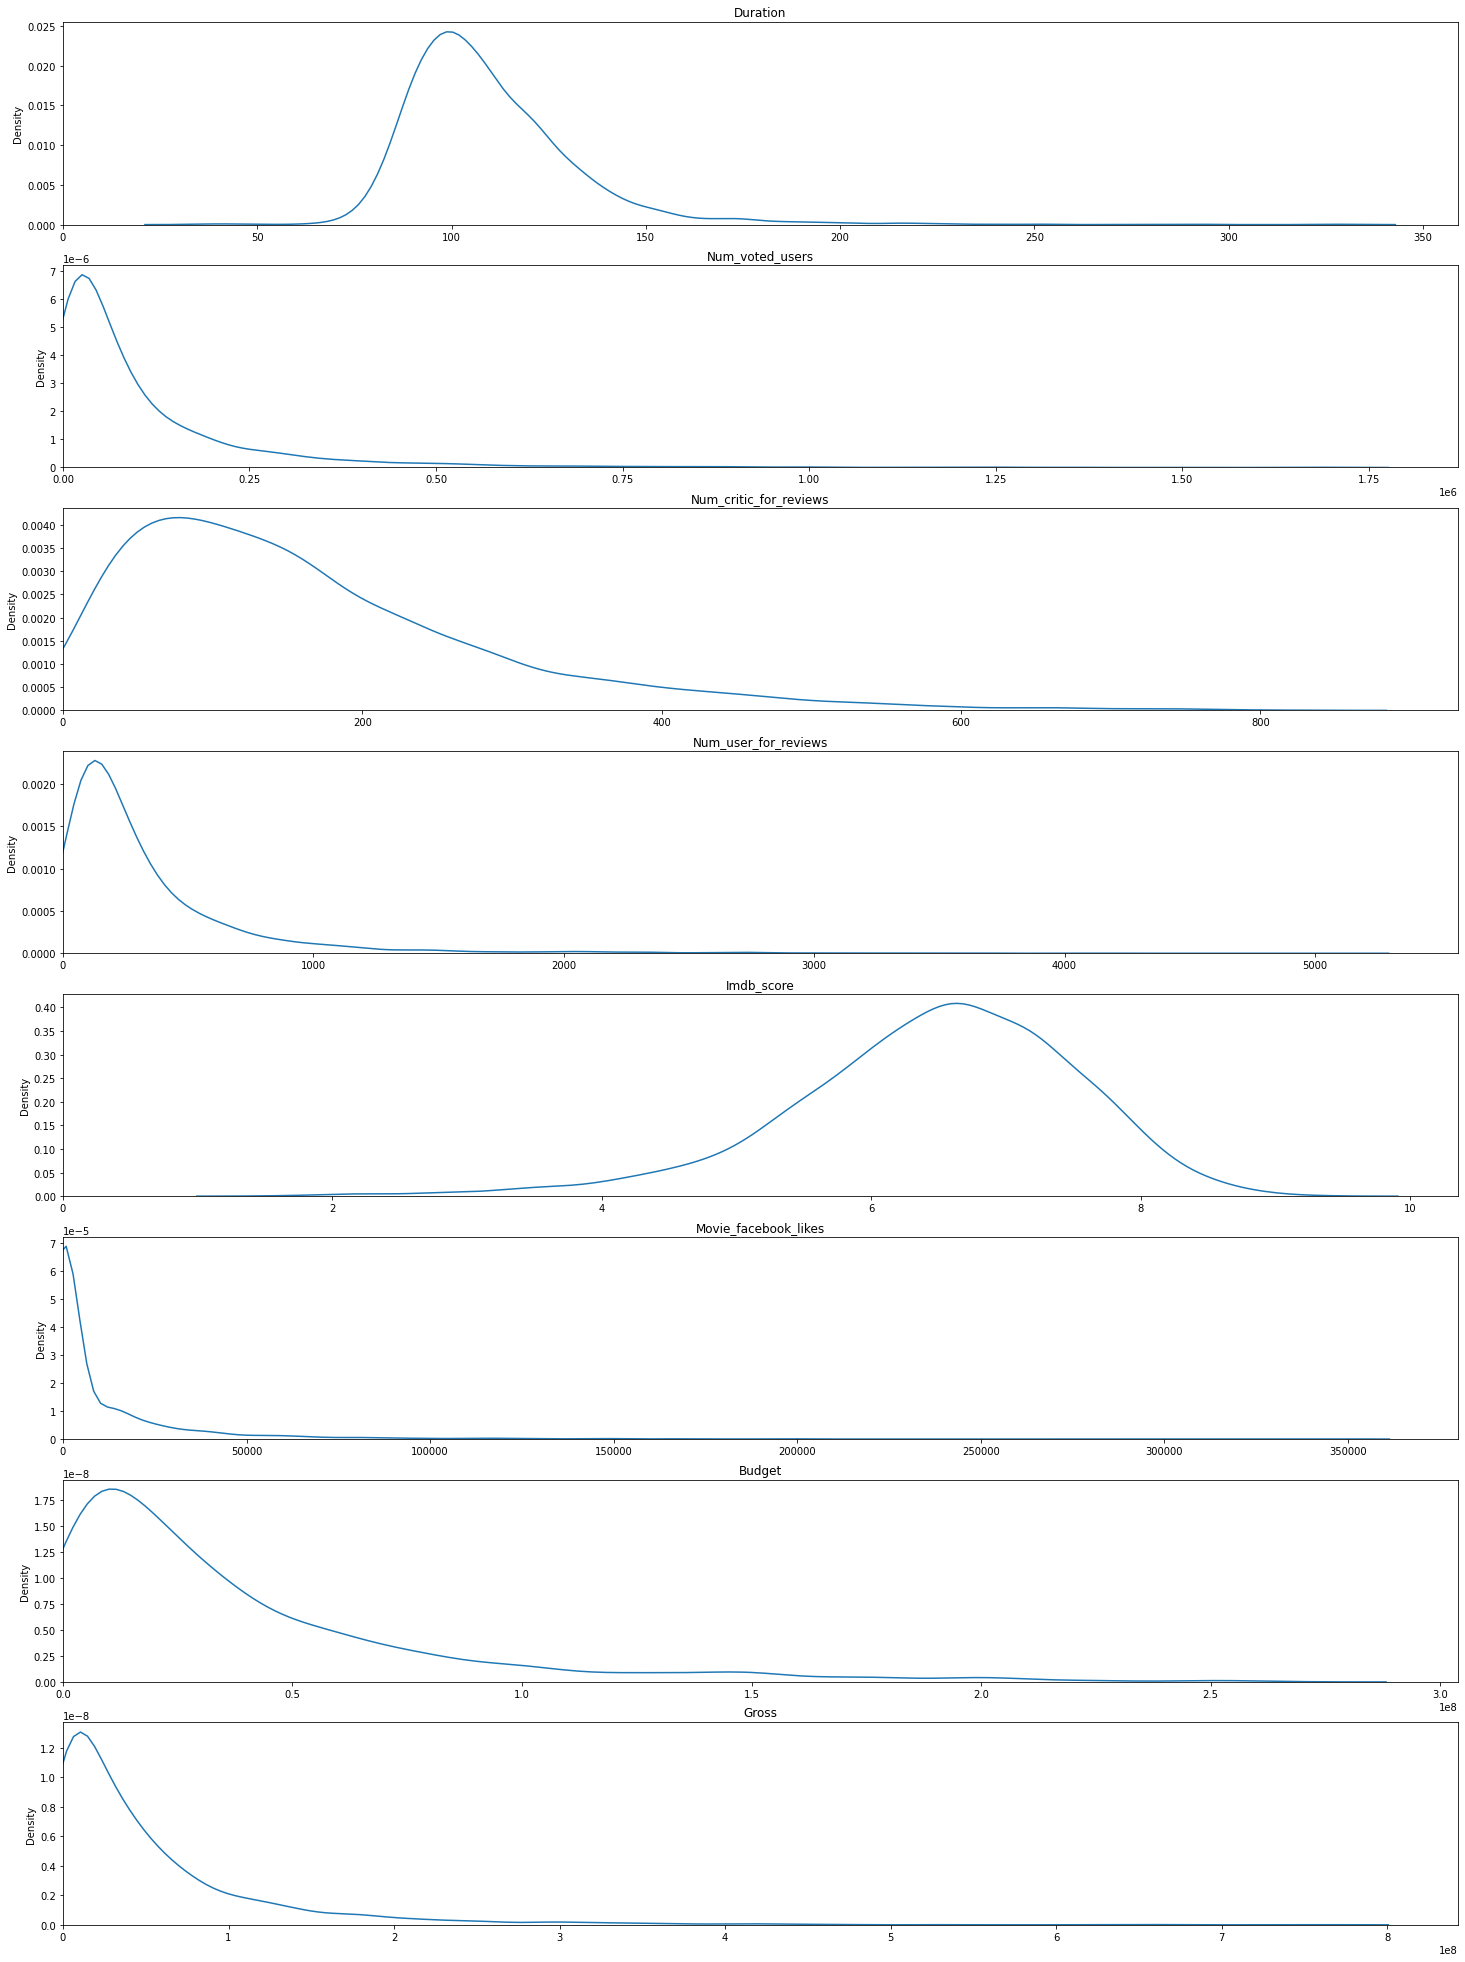

In [9]:
col_name_list = [col for col in list(feature_table.columns) if col not in ['movie_title', 'imdb_title_id', 'director_name']]
col_data_list = [feature_table[x] for x in col_name_list]


fig, ax = plt.subplots(len(col_data_list),1)
fig.set_size_inches(25, 35)

for x in range(len(col_name_list)):
    sns.kdeplot(np.array(col_data_list[x]), ax = ax[x]).set(title= col_name_list[x].capitalize(), xlim = (0))

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]


<h2>Outlier onderzoek: </h2>

Hier kijken we naar de outliers in de data. 

Een outlier word hier gedefiniëerd als een datapunt wat 3 standaarddeviaties boven of onder het gemiddelde ligt.

In [10]:
#wij hantered hier de vuistregel dat waardes die 1.5IQR onder de Q1 liggen outliers OF 1.5IQR boven Q3 , outliers zijn.
#Ook hanteren wij hier de regel dat waardes die 3QR onder de Q1 liggen outliers OF 3IQR boven Q3 ,  STERKE outliers zijn.

#deze functie heeft 3 parameters:
#1e parameter: sterke van outliers die eruit worden gefilterd word. 
# 's' = strong, wat betekent dat dat alleen de sterke outliers er uit worden gefilterd.
# 'a' = all, wat betekent dat dat alle  outliers er uit worden gefilterd.
# We hebben bewust gekozen om geen optie te maken om ALLEEN de zwakke outliers weg te filteren. Dit lijkt ons niet logisch

#De 2e parameter:
# het dataframe waar de outliers worden uitgefilterd.

#De 3e parameter:
# Een lijst kolomen waar de de outliers worden uitgefilterd. bijv ['US_gross', 'duration']

#voorbeeld aanroep functie:
# column_outlier('a', featuretable, ['US_gross', 'duration', 'budget'])


def column_outlier(strength, dataframe, columns):
    temp_dataframe = dataframe.copy()
    try:
        if strength == 's':
            strength=3
        elif strength == 'a':
            strength=1.5
    except:
        print("Invalid strength")
    for column in columns:
        Q1 = temp_dataframe[column].quantile(0.25)
        Q3 = temp_dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        temp_dataframe = temp_dataframe[~((temp_dataframe[column] < (Q1 - strength * IQR)) |(temp_dataframe[column] > (Q3 + strength* IQR)))]
    return temp_dataframe


<h2>Normaalverdeling meting:</h2>

Zoals we kunnen zien in onze densityplots, zijn onze features niet persé normaalverdeeld. Er zijn een aantal features waarbij dat nog in twijfel te trekken is, met name movie_facebook_likes, duration en gross. Dat gaan we nog nader onderzoeken.

Hier gebruiken we de normaltest van scipy stats om dat te controleren. Daar komen scores uit die inderdaad ondersteunen dat onze variabelen niet normaalverdeeld zijn. Een p score van hoger dan 0.05 is een indicatie voor een normaalverdeling.

Dat maakt het minder interessant om outliers te verwijderen, gezien het waarschijnlijk dan daadwerkelijk nuttige datapunten zijn.

In [11]:
print(stats.normaltest(feature_table['movie_facebook_likes']))
print(stats.normaltest(feature_table['duration']))
print(stats.normaltest(feature_table['gross']))

NormaltestResult(statistic=3712.504366370735, pvalue=0.0)
NormaltestResult(statistic=2061.1914809676896, pvalue=0.0)
NormaltestResult(statistic=2609.3259761327777, pvalue=0.0)


<h1> Korte data-analyse </h1>

Hieronder doen we een aantal visualisaties om alvast wat inzicht te krijgen in eventuele correlaties tussen de data. Dit geeft een beetje en idee van hoe de data eruit ziet. We beginnen met een correlatiematrix, en zoomen dan in op bepaalde correlaties.

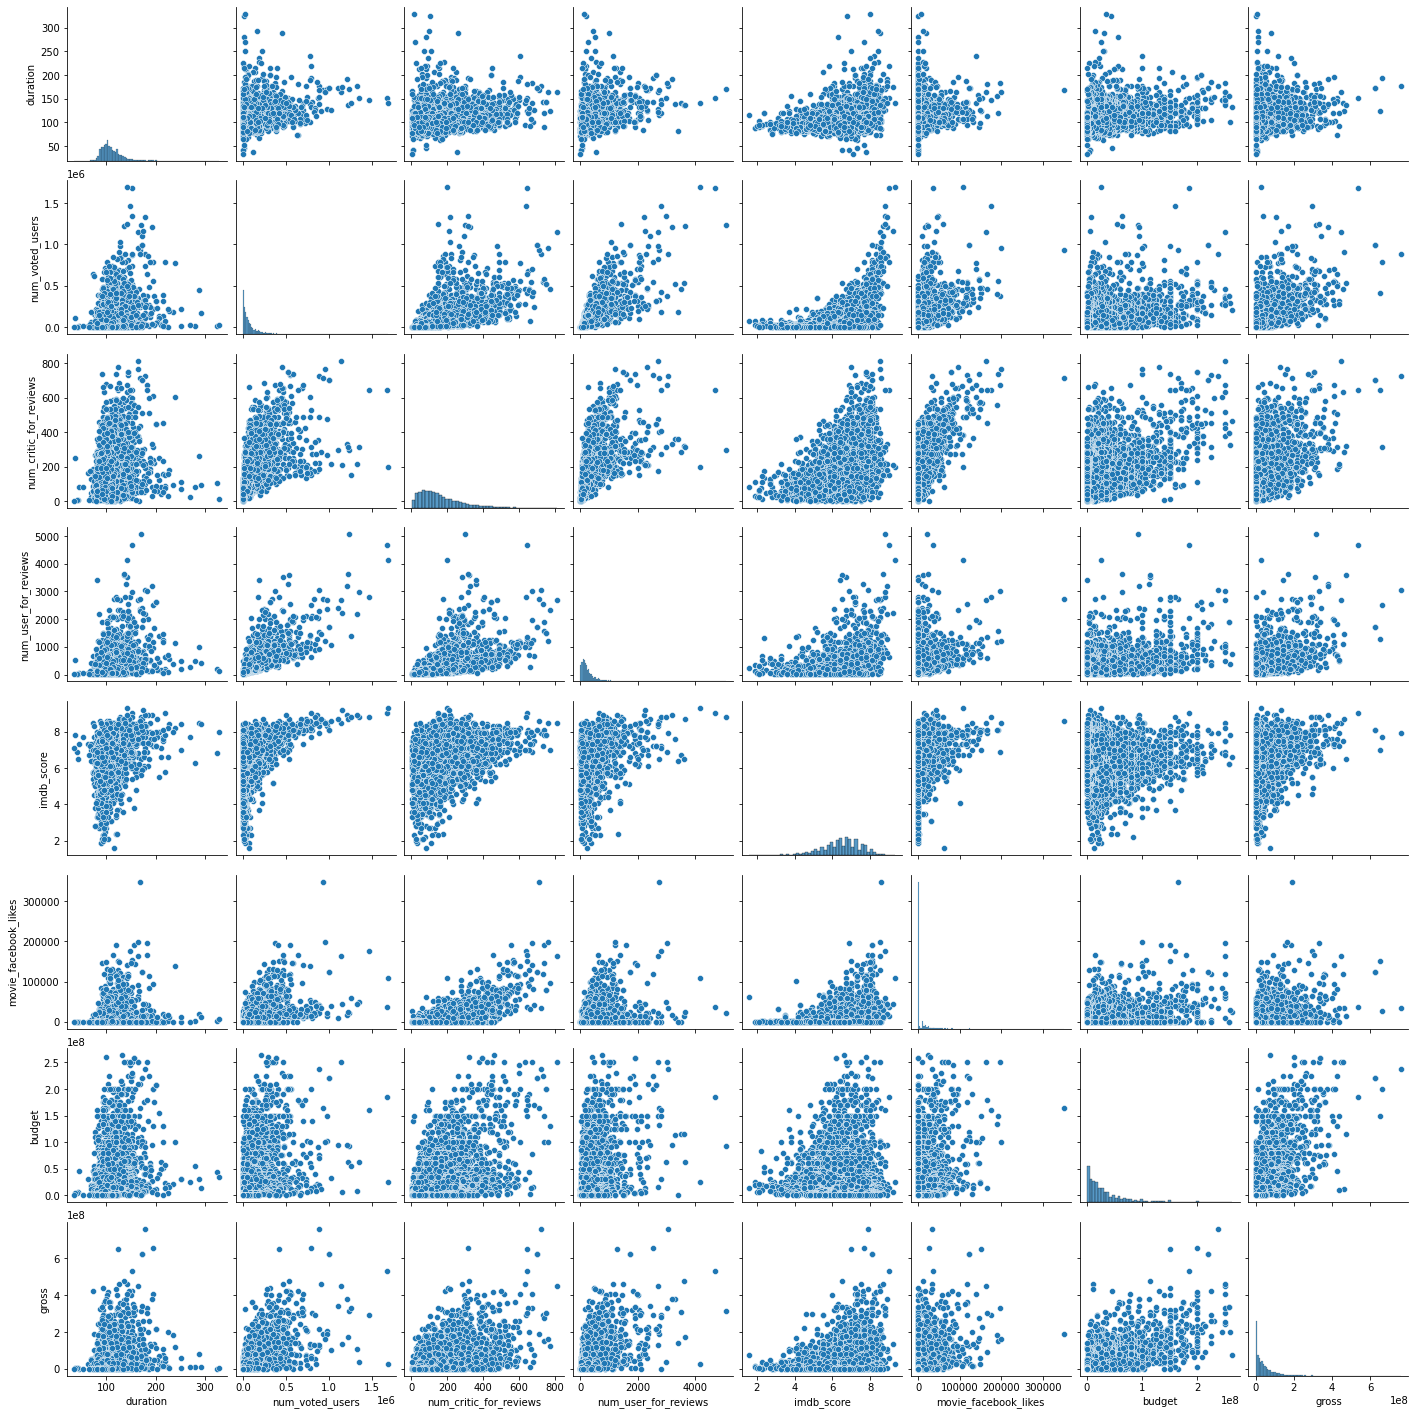

In [12]:
data_analysis_table = feature_table.copy() #make a copy of the table
data_analysis_table.dropna(inplace=True) #drop the NA's before making the graph
sns.pairplot(data_analysis_table) #plot a correlation matrix

We kunnen in de eerste oogopslag al zien dat er duidelijk correlaties te zien zijn. We gaan hieronder wat beter kijken naar een aantal van de correlatiematrices.

<h2> Correlatie IMDb Score vs Gross </h2>
Hier maken we een scatterplot om alvast te kijken naar de verhouding tussen imdb score en gross. Ook plotten we gelijk al een simpel linear regressie model. 

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


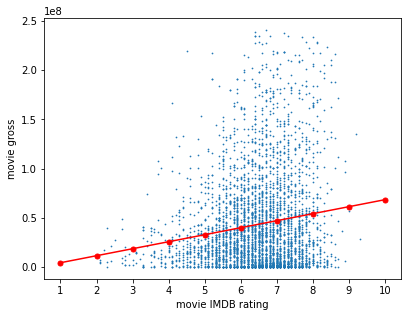

In [13]:
corr_imdb_table = feature_table.copy()[['imdb_score', 'gross']]

#remove all the strong outliers
corr_imdb_table =  column_outlier('s', corr_imdb_table, ['imdb_score', 'gross'])
X = corr_imdb_table[['imdb_score']]
y = corr_imdb_table[['gross']]

plt.xlabel('movie IMDB rating')
plt.ylabel('movie gross')

lm = linear_model.LinearRegression()
lm.fit(X, y)


pX = pd.DataFrame([1,2,3,4,5,6,7,8,9,10])


plt.plot([1,2,3,4,5,6,7,8,9,10],lm.predict(pX),
        marker='.', markerfacecolor='red', markersize=10, color = 'red')
plt.xticks(np.arange(0, 11, 1.0))

plt.scatter(X, y, s = .5)
plt.show()


We kunnen hier zien dat er zeker een correlatie te vinden is en dus is het interessant om verder te onderzoeken hoe zich dit verhoudt en of we dit kunnen gebruiken om voorspellingen te doen.

Er lijkt een vrij grote kluwe van films te bestaan die tussen de 5 en 8 scored, en het overgrote deel daarvan zet niet veel om. Dat klinkt als een logisch resultaat voor deze data, veruit de meeste films zijn gemiddeld. 

Wat ook opvalt is dat hoe hoger films scoren, hoe meer we datapunten gaan zien die ook veel omzetten. Er zijn dan ook vrij weinig films die onder de 6 scoren maar wel bovengemiddeld veel omzetten. Dat suggereert dat er een correlatie aanwezig is.

<h2> Correlatie facebook likes vs Gross</h2>
Hier zien we dat de correlatie tussen facebook likes en gross er heel anders uit ziet. Er is duidelijk een veel minder sterke correlatie te herkennen. Een lineare regressiemodel lijkt hier nauwelijks nuttig.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


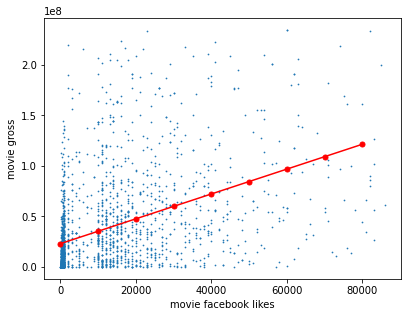

In [14]:
corr_table = feature_table.copy()
#replace values with the value 0 in the column movie_facebook_likes with np.NaN, since no movie actually has 0 facebook likes
#it functions as a NULL value but screws with our data
corr_table['movie_facebook_likes'] =  corr_table['movie_facebook_likes'].replace(0, np.NaN)

#remove all the strong outliers
corr_table = column_outlier('s', corr_table, ['movie_facebook_likes', 'gross'])

#drop all the nan valuees
corr_table.dropna(inplace=True)

x = corr_table[['movie_facebook_likes']]
y = corr_table[['gross']]

#Try a simple linear regression model 
lm = linear_model.LinearRegression()

#fit it to our data
lm.fit(x, y)

#make some plot points
pX = pd.DataFrame([0,10000,20000,30000,40000,50000,60000,70000,80000])

#plot the linear regression
plt.plot([0,10000,20000,30000,40000,50000,60000,70000,80000],lm.predict(pX),
        marker='.', markerfacecolor='red', markersize=10, color = 'red')

plt.xlabel('movie facebook likes')
plt.ylabel('movie gross')

plt.scatter(x, y, s = .5)
plt.show()

Er zijn een aantal conclusies te trekken op basis van deze grafiek. Zelfs met de sterke outliers verwijderd, lijkt er nog geen sterke correlatie te zijn in deze data.

 Wat wel opvalt is dat er een grote kluwe aan films is die nauwelijks likes heeft op facebook en wat ook opvallend is, is dat daar ook relatief veel films zijn die weinig omzetten. 

<h2> Table merge process </h2>



Voor dit project hebben wij een tweede dataset gevonden op Kaggle (https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset) met IMDb data. Die gaan we in het onderstaande codeblock samenvoegen met de gegeven database.

Daarvoor moeten we een aantal dingen doen. De eerste stap is om in de 2e tabel de kolom "movie_facebook_likes" toe te voegen en te vullen met NaNs, dat maakt het samenvoegen van de twee tabellen makkelijker.

Vervolgens zorgen we ervoor dat beide tabellen voor dezelfde informatie ook dezelfde colomnamen gebruiken. 

We gebruiken de IMDb ID als index. In de gegeven database is dit een ID, maar in onze database is het een link waar de ID in zit. Die trimmen we om de ID te extraheren. 

Als we dat hebben gedaan voegen we de twee databases samen en verwijderen dubbele waardes.

In [15]:
table2.describe()

,duration,avg_vote,votes,metascore,reviews_from_users,reviews_from_critics
count,85855.000,85855.000,85855.000,13305.000,78258.000,74058.000
mean,100.351,5.899,9493.490,55.897,46.041,27.480
std,22.554,1.235,53574.360,17.785,178.511,58.339
min,41.000,1.000,99.000,1.000,1.000,1.000
25%,88.000,5.200,205.000,43.000,4.000,3.000
50%,96.000,6.100,484.000,57.000,9.000,8.000
75%,108.000,6.800,1766.500,69.000,27.000,23.000
max,808.000,9.900,2278845.000,100.000,10472.000,999.000


In [16]:
table2.isnull().sum()

imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                     64
language                   833
director                    87
writer                    1572
production_company        4455
actors                      69
description               2115
avg_vote                     0
votes                        0
budget                   62145
usa_gross_income         70529
worlwide_gross_income    54839
metascore                72550
reviews_from_users        7597
reviews_from_critics     11797
dtype: int64

Hieronder hebben we een functie gemaakt waar we het budget uit de nieuwe tabel "rechttrekken".

In onze originele tabel zijn al onze budget/gross waardes in USD. In deze nieuwe database staan er allerlei munteenheden doorelkaar. We hebben ervoor gekozen om alleen de waardes in USD te houden. Die staan in onze nieuwe database aangeduid als "$*amount*". We strippen hieronder het dollarteken van het bedrag af en houden vervolgens alleen de rows waar het budget/gross een getal is. Alle andere waardes hebben nog een andere munteenheid ervoor staan en worden dus niet meegenomen.

We hadden er ook voor kunnen kiezen om munteenheden om te zetten maar hoe meer we daar over nadachten hoe ingewikkelder dat leek. 

In [17]:
def normalize_budget_gross():
    """the budget/gross of the second dataset uses a different format, we only keep the values already in USD"""

    def isnumber(x):
        try:
            float(x)
            return x
        except:
            return np.NaN

    table2['budget'] = table2['budget'].str.replace('$', '')
    table2['usa_gross_income'] = table2['usa_gross_income'].str.replace('$', '')
    table2['worlwide_gross_income'] = table2['worlwide_gross_income'].str.replace('$', '')


    table2['budget'] = table2['budget'].map(isnumber)
    table2['usa_gross_income'] = table2['usa_gross_income'].map(isnumber)
    table2['worlwide_gross_income'] = table2['worlwide_gross_income'].map(isnumber)

normalize_budget_gross()


#replace values with the value 0 in the column movie_facebook_likes with np.NaN, since no movie actually has 0 facebook likes
#it functions as a NULL value but screws with our data
table['movie_facebook_likes'] =  table['movie_facebook_likes'].replace(0, np.NaN)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  # This is added back by InteractiveShellApp.init_path()
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  if sys.path[0] == '':
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  del sys.path[0]


Hieronder maken we de tabellen klaar om te mergen. We passen een aantal kolomnamen aan, vullen de facebook_likes kolom in de nieuwe tabel met NaNs, omdat de nieuwe tabel geen facebook likes bevat, en voegen ze samen. Vervolgens halen we alle dubbele IMDB_ids weg.

In [18]:
# the second data set has no facebook_likes so we create an empty column
table2['movie_facebook_likes'] = np.NaN

#trim both tables so we only have the right feature variables
feature_table = table[['movie_title','duration', 'movie_imdb_link', 'num_voted_users', 'num_critic_for_reviews', 'num_user_for_reviews','imdb_score', 'movie_facebook_likes','budget', 'gross', 'director_name']]
feature_table2 = table2[['original_title', 'duration', 'imdb_title_id', 'votes', 'reviews_from_critics', 'reviews_from_users', 'avg_vote','movie_facebook_likes', 'budget','usa_gross_income','worlwide_gross_income', 'director' ]]


# change the movie_imdb_link to a imdb_title_id
feature_table["movie_imdb_link"]= feature_table["movie_imdb_link"].str.split("/", n = 5, expand = True)[4]
feature_table = feature_table.rename(columns={"movie_imdb_link": "imdb_title_id"})

#change the names of the columns of the second table to corresponding collumn names of the first table
feature_table2 = feature_table2.rename(columns={"avg_vote": "imdb_score", 'original_title':'movie_title', 'votes':'num_voted_users', 'usa_gross_income':'US_gross','worlwide_gross_income':'worldwide_gross', 'reviews_from_critics': 'num_critic_for_reviews', 'reviews_from_users': 'num_user_for_reviews', 'director':'director_name'})
feature_table = feature_table.rename(columns={'gross': 'US_gross'})


#append table2 to table
new_df = feature_table.append(feature_table2)

#remove duplicates from the merged tables
new_df.drop_duplicates(subset ="imdb_title_id",
                     keep = 'first', inplace = True)


#cast all values in the  gross and budget columns to floats
new_df.US_gross = pd.to_numeric(new_df.US_gross)
new_df.worldwide_gross = pd.to_numeric(new_df.worldwide_gross)
new_df.budget = pd.to_numeric(new_df.budget)



/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Nu kijken we even naar de lengte van ons nieuw gemaakte dataframe en zien we dat we beschikken over 86000 films. 

In [19]:
len(new_df)

86183

In [20]:
new_df

,movie_title,duration,imdb_title_id,num_voted_users,num_critic_for_reviews,num_user_for_reviews,imdb_score,movie_facebook_likes,budget,US_gross,director_name,worldwide_gross
0,Avatar,178.000,tt0499549,886204,723.000,3054.000,7.900,33000.000,237000000.000,760505847.000,James Cameron,NaN
1,Pirates of the Caribbean: At World's End,169.000,tt0449088,471220,302.000,1238.000,7.100,NaN,300000000.000,309404152.000,Gore Verbinski,NaN
2,Spectre,148.000,tt2379713,275868,602.000,994.000,6.800,85000.000,245000000.000,200074175.000,Sam Mendes,NaN
3,The Dark Knight Rises,164.000,tt1345836,1144337,813.000,2701.000,8.500,164000.000,250000000.000,448130642.000,Christopher Nolan,NaN
4,Star Wars: Episode VII - The Force Awakens ...,NaN,tt5289954,8,NaN,NaN,7.100,NaN,NaN,NaN,Doug Walker,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
85850,Le lion,95.000,tt9908390,398,4.000,NaN,5.300,NaN,NaN,NaN,Ludovic Colbeau-Justin,3507171.000
85851,De Beentjes van Sint-Hildegard,103.000,tt9911196,724,4.000,6.000,7.700,NaN,NaN,NaN,Johan Nijenhuis,7299062.000
85852,Padmavyuhathile Abhimanyu,130.000,tt9911774,265,NaN,NaN,7.900,NaN,NaN,NaN,Vineesh Aaradya,NaN
85853,Sokagin Çocuklari,98.000,tt9914286,194,NaN,NaN,6.400,NaN,NaN,NaN,Ahmet Faik Akinci,2833.000


<h2> 1. In hoeverre is de omzet van een film te voorspellen op basis van de populariteit op Facebook en IMDB? </h2>

We gaan hier een simpel lineare regressiemodel op los laten. We maken daarvoor eerst een tijdelijke copy van onze dataframe, droppen alle NA's, en splitten onze set op in een train en testset. 
Vervolgens roepen we sklearns lineare regressie functie aan en trainen deze op onze trainingsset.

In [21]:
#maak tijdelijk dataframe aan met alleen de kollomen die we gebruiken Gross voorspellend model
line_df = new_df[['movie_facebook_likes','imdb_score','US_gross']].copy(deep=True)

#drop all nans 
line_df = line_df.dropna()

# verwijder outliers
line_df =  column_outlier('a', line_df, ['movie_facebook_likes','imdb_score','US_gross'])

# onafhankelijke variabelen zijn: imdb_score & movie_facebook_likes
# afhankelijke variabele is US_gross

#Hier maken we onderscheid tussen een train en test set. De size van de test set is 33% van het de complete set. De training set is dus 67%
train_df, test_df = train_test_split(line_df, test_size = 0.33)

#Hier wordt het model gemaakt op basis van de eerder gemaakt xtrain en ytrain
regr = linear_model.LinearRegression().fit(train_df[['movie_facebook_likes','imdb_score']], train_df['US_gross'])

In [22]:
 # nu willen we het hierboven gemaakte model valideren door de test set in te laden in het eerder gemaakte model
# hiervan willen we de voorspellde waarden vergelijken met de waarden uit het dataframe
#ook berekenen we hier de RSME door de formule die gegeven staat op https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error/

predicted=0
verschil=0
results=[]
RMSE=0
for  index, row in test_df.iterrows(): 
    
    gross = row['US_gross']
    predicted = float(regr.predict([[row['movie_facebook_likes'],row['imdb_score']]]))
    verschil = row['US_gross'] - predicted
    
    #hier berekenen we: (verschil^2) / lengte van de set
    RSME_value = (verschil * verschil) / len(test_df.US_gross)

    results.append(RSME_value)
RSME=(sqrt(sum(results)))



  "X does not have valid feature names, but"
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:4

In [23]:
print(RSME)

26851381.831200738


In [24]:
df_copy = line_df[['movie_facebook_likes','imdb_score','US_gross']].copy(deep=True)

# plot 1/1e van de data, anders is het plot te druk
df_copy = df_copy.sample(frac=0.10)

fig = px.scatter_3d(df_copy, x='movie_facebook_likes', y='US_gross', z='imdb_score')
fig.show()

<AxesSubplot:xlabel='imdb_score', ylabel='movie_facebook_likes'>

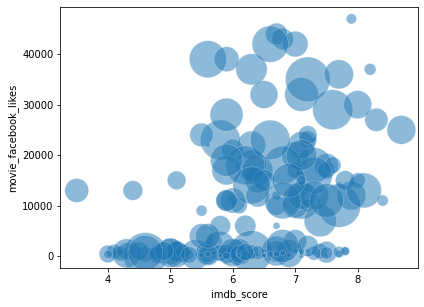

In [25]:
sns.scatterplot(data=df_copy, x="imdb_score", y="movie_facebook_likes", size="US_gross", legend=False, sizes=(20, 2000), alpha=0.5)

<h4> Conclusie: </h4>

De voorspelling van de gross door middel van linear regression is redelijk. De RSME is +- 29miljoen, wat op een database van films waar tot in de honderden miljoenen kan lopen toch relatief accuraat. Mogelijk is dit model beter wanneer er meer feature variabelen worden toegevoegd.

Al met al is dit model succesvol.

<h2> 2. Kun je voorspellen of een film winst of verlies heeft gemaakt op basis van variabelen in de database: </h2>

Om deze onderzoeksvraag te beantwoorden hebben we ervoor gekozen om een aantal verschillende machine learning modellen uit te proberen.

We beginnen hier eerst met wat voorbereiding. 
We droppen de nan waardes uit de relevante kolommen, en maken een nieuwe kolom "profit" aan, die simpelweg gross - budget bevat. 

Verder maken we profit_positive aan, een boolean die ons verteld of een film winst heeft gemaakt of niet. 

Vervolgens passen we kolommen zo aan dat we alleen nog relevante feature variabelen hebben. 

Ook laten we facebook_likes gaan, omdat we simpelweg te weinig data hebben om een nuttige voorspelling te maken.

In [26]:
prof_df = new_df.copy()
prof_df = prof_df[prof_df['budget'].notna()]
prof_df = prof_df[prof_df['worldwide_gross'].notna()]


prof_df["profit"] = prof_df["worldwide_gross"] - prof_df["budget"]

#heeft de film winst gemaakt 1 of 0
prof_df['profit_positive'] = np.where(prof_df['profit']> 0, 1, 0)

#movie_facebook_likes heeft wel degelijk een correlatie met de profit, maar helaas heeft de kolom te veel NaN waardes om te gebruiken
prof_df = prof_df[['duration','num_voted_users', 'num_critic_for_reviews', 'num_user_for_reviews', 'imdb_score', 'budget', 'profit_positive']]

pp = prof_df.profit_positive
prof_df = prof_df.loc[:, prof_df.columns!='profit_positive']

Drop alle NaN waardes:

In [27]:
prof_df = prof_df.dropna()

Hier normaliseren we de data. Een aantal van onze machinelearning modellen scoren beter op genormaliseerde data, en geen enkele methode scoort slechter.

In [28]:
prof_df = (prof_df-prof_df.mean())/prof_df.std()
prof_df['profit_positive'] = pp

Hier kijken we naar de correlatie tussen profit en andere feature variabelen via de pearson methode, maar niks lijkt sterk gecorreleerd. Echter lijkt het ons wel haalbaar om een model te maken wat beter scoort dan simpelweg gokken. 

In [29]:
prof_df.corr(method = 'pearson')

,duration,num_voted_users,num_critic_for_reviews,num_user_for_reviews,imdb_score,budget,profit_positive
duration,1.000,0.240,0.217,0.228,0.344,0.248,0.136
num_voted_users,0.240,1.000,0.767,0.736,0.347,0.566,0.344
num_critic_for_reviews,0.217,0.767,1.000,0.690,0.321,0.557,0.353
num_user_for_reviews,0.228,0.736,0.690,1.000,0.208,0.588,0.262
imdb_score,0.344,0.347,0.321,0.208,1.000,0.093,0.214
budget,0.248,0.566,0.557,0.588,0.093,1.000,0.224
profit_positive,0.136,0.344,0.353,0.262,0.214,0.224,1.000


Hieronder defeniëren we een aantal machine learning modellen.

We maken gebruik van: 

Logistic regression

Decision trees

Random forests

Support Vectors

k_nearest_neighbours

En zullen onderzoeken welk machine learning model het beste werkt om te voorspellen of een film profitable is.


In [30]:
def logistic_regression(sets):
    

    logreg = LogisticRegression()
    logreg.fit(sets['X_train'], sets['y_train'].values.ravel())
    y_pred = logreg.predict(sets['X_test'])

    return metrics.accuracy_score(sets['y_test'], y_pred)


def decision_tree(sets, criterion, max_depth):
    
    clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth)

    clf = clf.fit(sets['X_train'],sets['y_train'].values.ravel())

    y_pred = clf.predict(sets['X_test'])

    return metrics.accuracy_score(sets['y_test'], y_pred)



def random_forests(sets,criterion, max_depth):
    
    rclf = RandomForestClassifier(criterion = criterion, max_depth=max_depth)
    rclf.fit(sets['X_train'], sets['y_train'].values.ravel())

    y_pred = rclf.predict(sets['X_test'])
    return metrics.accuracy_score(sets['y_test'], y_pred)


def support_vectors(sets):
 
    svclf = svm.SVC()
    svclf.fit(sets['X_train'], sets['y_train'].values.ravel())
    y_pred = svclf.predict(sets['X_test'])
    
    return metrics.accuracy_score(sets['y_test'], y_pred)

def k_nearest_neighbors(sets,k):
    
    from sklearn.neighbors import KNeighborsClassifier
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(sets['X_train'].values, sets['y_train'].values.ravel())
    y_pred = neigh.predict(sets['X_test'].values)
    
    return metrics.accuracy_score(sets['y_test'], y_pred)

<h3> Hyperparameters </h3>

Het is voor decision trees, random forests en k-nearest neighbours een beetje te experimenteren met wat de beste hyperparameters zijn. Hieronder hebben we meerdere functies gedefinieërd die de beste hyperparameters voor verschillende ML modellen bepalen. We doen dit door de dataframe random te splitsen in test en train sets, en dan x keer het model te laten fitten en predicten, en de mean accuracy van de predict op te slaan. We gebruiken vervolgens de hyperparameter met de hoogste mean accuracy. Bijvoorbeeld k = 31 voor KNN.

In [31]:
# berken de optimale depth en criterion voor een decision tree / random forest
def test_optimal_tree(title, iterations, max_depth, method, X, y):

    acc_list_gini = []
    for i in range(1,max_depth+1):
        pred_list = []
        for z in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
            sets = {'X_train': X_train, 'y_train':y_train, 'X_test': X_test, 'y_test': y_test}

            
            pred_list.append(eval(f"{method}(sets, 'gini',i)"))
        acc_list_gini.append(np.mean(pred_list))


    acc_list_entropy = []
    for i in range(1,max_depth+1):
        pred_list = []
        for z in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
            sets = {'X_train': X_train, 'y_train':y_train, 'X_test': X_test, 'y_test': y_test}

            pred_list.append(eval(f"{method}(sets, 'gini',i)"))
        acc_list_entropy.append(np.mean(pred_list))


    x = [i for i in range(1,max_depth+1)]
    y1 = acc_list_gini

    plt.plot(x, y1, label = "line 1")

    y2 = acc_list_entropy

    plt.plot(x, y2, label = "line 2")

    plt.xlabel('depth')
    plt.ylabel('accuracy score')

    plt.title(title)

    plt.legend()

    L=plt.legend()
    L.get_texts()[0].set_text('Gini')
    L.get_texts()[1].set_text('Entropy')

    plt.show()

<h3> Random forests tests </h3>

Hieronder testen we onze random forest, en kijken op welke depths entropy of gini het best presteren.

note: het runnen van meer iteraties geeft een accuraater resultaat maar duurt ook aanzienlijk langer, daarom laten we hier beneden een demo zien, de graphs waarop de echte waardes zijn gebaseerd zijn te vinden in de 'hyperparameter charts vraag 2' map.

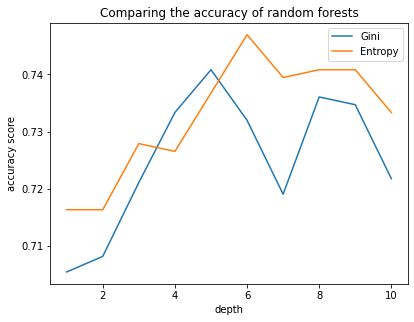

In [32]:

# wat is de optimale depth en criterion voor random forests?
test_optimal_tree('Comparing the accuracy of random forests', 1,10,'random_forests', prof_df.loc[:, prof_df.columns != 'profit_positive'],prof_df.loc[:, prof_df.columns == 'profit_positive'])


# 20 iteraties:
# optimale depth: 13
# optimale criterion: entropy

<h3> Decision trees tests</h3>

Hieronder testen we onze decision tree, en kijken op welke depths entropy of gini het best presteren.

note: het runnen van meer iteraties geeft een accuraater resultaat maar duurt ook aanzienlijk langer, daarom laten we hier beneden een demo zien, de graphs waarop de echte waardes zijn gebaseerd zijn te vinden in de 'hyperparameter charts vraag 2' map.

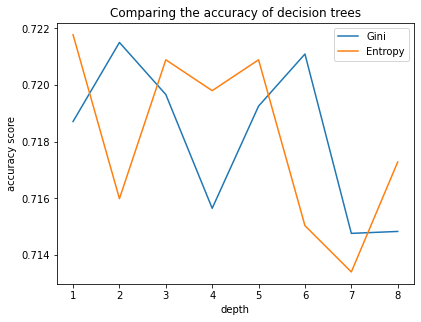

In [33]:
# wat is de optimale depth en criterion voor decision trees?
test_optimal_tree('Comparing the accuracy of decision trees',10,8,'decision_tree', prof_df.loc[:, prof_df.columns != 'profit_positive'],prof_df.loc[:, prof_df.columns == 'profit_positive'])


# 300 iteraties:
# optimale depth: 5
# optimale criterion: gini/entropy

<h3> KNN tests</h3>

Hieronder testen we KNN, en kijken we met welke k waarde deze het beste werkt.

note: het runnen van meer iteraties geeft een accuraater resultaat maar duurt ook aanzienlijk langer, daarom laten we hier beneden een demo zien, de graphs waarop de echte waardes zijn gebaseerd zijn te vinden in de 'hyperparameter charts vraag 2' map.

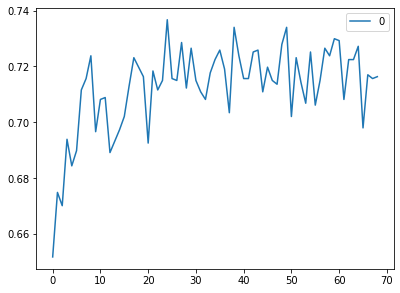

In [34]:
def test_optimal_k(iterations, X, y):

    # wat is de optimale k-value voor knn:
    # we runnen dit met veel meer iteraties zodat we de mean van de resultaten kunnen nemen, maar dit duurt natuurlijk erg lang, dit is een voorbeeld:
    m_list = []
    for i in range (1, round(len(y)**0.5)):

        t_list = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
            sets = {'X_train': X_train, 'y_train':y_train, 'X_test': X_test, 'y_test': y_test}

            t_list.append(k_nearest_neighbors(sets, i))
        m_list.append(np.mean(t_list))


    m_frame = pd.DataFrame(m_list)
    m_frame.plot()


X = prof_df.loc[:, prof_df.columns != 'profit_positive']
y = prof_df.loc[:, prof_df.columns == 'profit_positive']

test_optimal_k(1, X, y)

# de charts die we gebruikt hebben voor de hyperparameters zijn te vinden in de 'hyperparameter charts vraag 2' map
# 15 iteraties:
# optimale k: 31

In [35]:
def test_ml_models(i, X,y):
    
    vc = prof_df['profit_positive'].value_counts()

    #er zijn meer films die geen winst hebben gemaakt in onze dataset, 61%
    base_accuracy = vc[0]/(vc[0] + vc[1])

    lr_list = []
    dt_list = []
    rf_list = []
    sv_list = []
    knn_list = []

    for i in range(i):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        
        sets = {'X_train': X_train, 'y_train':y_train, 'X_test': X_test, 'y_test': y_test}


        lr = logistic_regression(sets)

        # the optimal depth and criterion for dt and rf were decided above
        dt = decision_tree(sets, 'gini', 5)
        rf = random_forests(sets,'entropy', 13)
        sv = support_vectors(sets)
        knn = k_nearest_neighbors(sets,31)


        lr_list.append(lr)
        dt_list.append(dt)
        rf_list.append(rf)
        sv_list.append(sv)
        knn_list.append(knn)  
        
        
        lr_mean = np.mean(lr_list)
        dt_mean = np.mean(dt_list)
        rf_mean = np.mean(rf_list)
        sv_mean = np.mean(sv_list)
        knn_mean = np.mean(knn_list)
        
    models = ['Base Chance','Support Vector Machines','Logistic Regression','K-Nearest Neighbors', 'Decision Tree', 'Random Forests']
    x_pos = np.arange(len(models))
    CTEs = [base_accuracy,sv_mean,lr_mean,knn_mean, dt_mean, rf_mean]
    error = [0,np.std(sv_list),np.std(lr_list),np.std(knn_list), np.std(dt_list), np.std(rf_list)]
    fig, ax = plt.subplots()
    ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Chance of correctly classifying a movie')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models)
    ax.set_title('Deciding the best ML model for predicting profitable movies')
    ax.yaxis.grid(True)

    plt.tight_layout()
    plt.xticks(rotation=360-25)
    plt.show()
    
    return {'base_accuracy': base_accuracy, 'lr_accuracy':lr_mean,'dt_accuracy':dt_mean, 'rf_accuracy':rf_mean, 'sv_accuracy':sv_mean, 'knn_accuracy':knn_mean}

<h3>Machine learning graphs </h3>

Hier onder laten we zien welke machine learning modellen het beste performen voor 3 verschillende X inputs:

- Alle kolommen met een positieve correlatie met de profit (zonder movie_facebook_likes, hier hebben we niet genoeg van)
- Alleen de kolom die de sterkste correlatie heeft met de profit
- Alleen de kolommen die bekend zijn <b>voordat</b> de film uitkomt, zodat we van te voren kunnen voorspellen of een film winst zal gaan maken

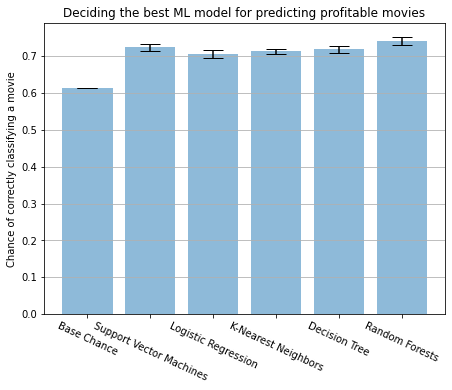

{'base_accuracy': 0.613265306122449,
 'lr_accuracy': 0.7067346938775511,
 'dt_accuracy': 0.718843537414966,
 'rf_accuracy': 0.740952380952381,
 'sv_accuracy': 0.7244897959183674,
 'knn_accuracy': 0.7137414965986395}

In [36]:
test_ml_models(5, prof_df.loc[:, prof_df.columns != 'profit_positive'], prof_df.loc[:, prof_df.columns == 'profit_positive'])

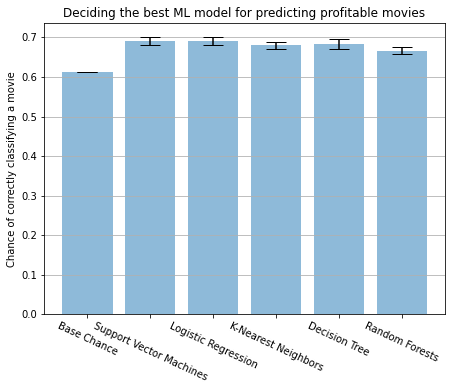

{'base_accuracy': 0.613265306122449,
 'lr_accuracy': 0.6906122448979592,
 'dt_accuracy': 0.683265306122449,
 'rf_accuracy': 0.6667346938775509,
 'sv_accuracy': 0.6902721088435373,
 'knn_accuracy': 0.6799319727891157}

In [37]:
test_ml_models(5, prof_df[['num_critic_for_reviews']], prof_df.loc[:, prof_df.columns == 'profit_positive'])

Hier kijken we wat er gebeurd als we alleen kolommen gebruiken in onze modellen die beschikbaar zijn voordat de film uitkomt. 

Is het mogelijk om voor het uitkomen van de film te voorspellen of een film winstgevend wordt?

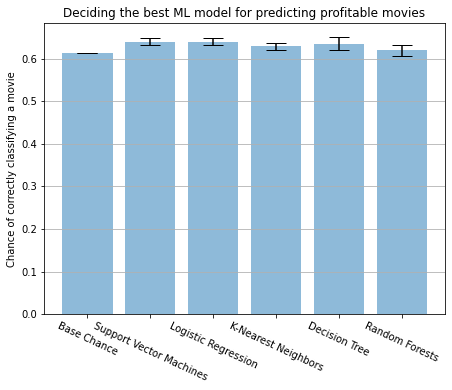

{'base_accuracy': 0.613265306122449,
 'lr_accuracy': 0.6398639455782315,
 'dt_accuracy': 0.6357142857142858,
 'rf_accuracy': 0.6194557823129251,
 'sv_accuracy': 0.6401360544217687,
 'knn_accuracy': 0.6289115646258503}

In [38]:
test_ml_models(5, prof_df[['duration', 'budget']], prof_df.loc[:, prof_df.columns == 'profit_positive'])

<h4> Conclusie: </h4>

De basis kans om een film succesvol te classificeren als winstgevend/niet winstgevend is ~61% omdat we werken met een licht 'lopsided' dataset. Als we gebruik maken van alle discrete/continue variabelen waar we genoeg data voor hebben, dan is random forests het machine learning model dat de beste voorspelling kan maken, met ~74% kans op een goede classificatie. We kijken ook of er modellen zijn die beter werken op minder X-kolommen, maar elk model gaat in nauwkeurigheid achteruit.

Het proberen te voorspellen of een film winstgevend zal zijn op basis van <b> alleen </b> maar variabelen die we al van te voren weten (duration, budget) werkt een stuk slechter. De beste modellen hebben daar een nauwkeurigheid van slechts ~64% voor.



<h2> 3. Kunnen we logische klusters vinden van regisseurs die winstgevende films maken of regisseurs die vaak verliesgevende films maken? </h2>

Voor deze onderszoeksvraag gaan we op zoek naar clusters, logischerwijs gebruiken we dus een clusterings algoritme.
We hebben gekozen voor een kmeans clustering model. 
Hier hebben we voor gekozen omdat we verwachten dat hier een mooie visualisatie van verschillende clusters uit zal komen.

We beginnen hier eerst met wat voorbereiding.
We maken een nieuw dataframe aan met alleen de kolomnen die relevant zijn bij deze onderzoeksvraag, namelijk:

- Movie title voor het identificeren van de films
- Director name voor het identificeren van de directors
- Budget
- worldwide_gross

We droppen de nan waardes uit de hierboven beschreven kolommen.
Dit doen we omdat een rij die een van deze kolomen niet bevat, niet relevant is. 

- Als budget of gross mist, kunnen we de profit niet uitrekenen. 
- Als de naam van de film of director mist, is het lastig om te identificeren en is het visueel niet appealing.
We maken een nieuwe kolom "profit" aan, die simpelweg gross - budget bevat.

Door middel van de set functie op de director_name kolomn toe te passen, krijgen we een lijst met alle unique director names uit het dataframe.

In [39]:
director_df = new_df[['movie_title','director_name','budget', 'worldwide_gross']].copy()
director_df = director_df.dropna()
director_df["profit"] = director_df["worldwide_gross"] - director_df["budget"]
unique_directors = set(director_df['director_name'])


In [40]:
director_df.head()

,movie_title,director_name,budget,worldwide_gross,profit
165,Das Cabinet des Dr. Caligari,Robert Wiene,18000.000,8811.000,-9189.000
245,The Four Horsemen of the Apocalypse,Rex Ingram,800000.000,9183673.000,8383673.000
251,The Kid,Charles Chaplin,250000.000,26916.000,-223084.000
348,A Woman of Paris: A Drama of Fate,Charles Chaplin,351000.000,11233.000,-339767.000
415,The Gold Rush,Charles Chaplin,923000.000,26916.000,-896084.000


Hier wordt door middel van list comprehension een lijst aangemaakt waarin per director het volgende word berekend:
- gemiddelde profit per film
- maximale profit van een enkele film
- minimale profit van een enkele film



In [41]:
performance_list = [[ud,np.mean(director_df[director_df['director_name'] == ud]['profit']),np.min(director_df[director_df['director_name'] == ud]['profit']),np.max(director_df[director_df['director_name'] == ud]['profit']),len(director_df[director_df['director_name'] == ud]['profit'])]for ud in unique_directors]

Hier wordt de hierboven berekende data toegevoegd aan het dataframe wat gebruikt wordt voor de betreffende onderzoeksvraag.

Ook plotten we een scatter plot van directors hun minimale profit op de X - as, en hun maximale profit op de Y - as.

<AxesSubplot:xlabel='min_profit', ylabel='max_profit'>

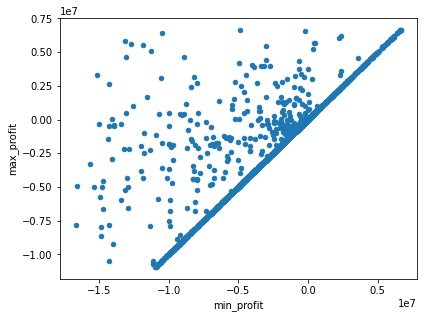

In [42]:
performance_df = pd.DataFrame(performance_list, columns=['director_name', 'mean_profit', 'min_profit','max_profit','number_of_movies'])

performance_df = column_outlier('a', performance_df.copy(), ['mean_profit', 'min_profit','max_profit'])

performance_df.plot.scatter('min_profit', 'max_profit')

In het bovenstaande scatterplot is een rechte lijn van punten te zien.

Deze punten zijn directors wiens maximale profit gelijk is aan hun minimale profit. Ofwel directors met maar 1 film met voldoende data in de dataframe.

In de onderstaande code worden deze directors er uit gefilterd. We hebben hier besloten om alleen directors met minimaal 2 films in de onderstaande plots te tonen.

We hebben in ons model gekozen om 5 clusters te maken. Visueel gezien maakt dit de mooiste plot.

Als we de clusters visualiseren als volgt:

              5
            4
          3  
        2
      1

Uit dit plot hebben wij de volgende observaties gemaakt:
- cluster 1: Directors met hele lage max en mean winst.
- cluster 2: Directors met vooral negatieve max winst en een gemiddeld negatieve winst.
- cluster 3: Directors met soms profitable films ,maar gemiddeld nog verlies draaien.
- cluster 4: Directors met vaak break even gaan.
- cluster 5: Directors die hoge max profits hebben, maar gemiddeld erg verspreid zijn.



/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



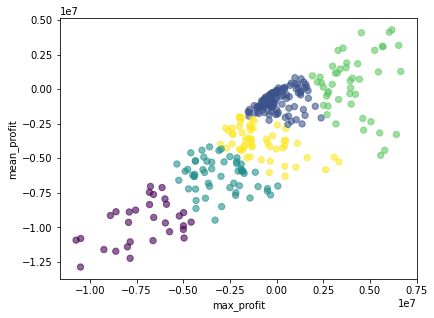

In [48]:

plot_df = performance_df[performance_df['number_of_movies']>=2]

kmeans = KMeans(n_clusters=5)
plot_df['cluster'] = kmeans.fit_predict(plot_df[['max_profit', 'mean_profit']])

plt.xlabel('max_profit')
plt.ylabel('mean_profit')
plt.scatter(plot_df.max_profit, plot_df.mean_profit, c= plot_df['cluster'], alpha = 0.6, s = 40)


Hier onder plotten we per director de min profit tegen de mean profit.

Voor het volgende plot hebben we opnieuw gekozen om per director minimaal 2 films te verwachten.

Bij deze plot hebben we gekozen voor k = 4. Hier hebben we voor gekozen omdat de geplotte data redelijk 'recht' is. 

Een grotere K zou deze data alleen in meer stukjes slicen maar zou verder geen bijzondere clusters identificeren.
Een kleinere K maakt de clusters erg uitgerekt waardoor er te veel verschillende types directors per clusters terecht komen.


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



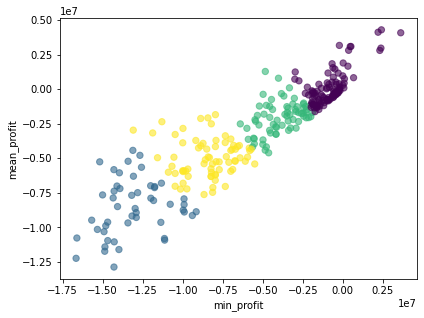

In [44]:
plot_df = performance_df[performance_df['number_of_movies']>=2]


kmeans = KMeans(n_clusters=4)
plot_df['cluster'] = kmeans.fit_predict(plot_df[['min_profit', 'mean_profit']])


plt.ylabel('mean_profit')
plt.xlabel('min_profit')

plt.scatter(plot_df.min_profit, plot_df.mean_profit, c=plot_df['cluster'], alpha = 0.6, s=40)

<h4> Conclusie: </h4>

Er zijn duidelijke clusters te maken met directors. Er is goed visueel onderscheid te maken tussen de clusters, waardoor het ook mogelijk word om conclusies te trekken uit de visualisatie. Dit is hierboven ook gedaan.

Een groot nadeel van onze aanpak is dat directors met maar één film in het dataframe, niet worden meegerekend. Hierdoor is het criteria voor de clustering redelijk scherp.



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fa303027-8f24-4998-bfdf-da8e717bac1e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>